# Train Models

In [137]:
# imports
import numpy as np
import pandas as pd
from pathlib import Path
import pickle

from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, f1_score, accuracy_score, roc_auc_score, precision_recall_curve, precision_score, recall_score
from sklearn.base import clone
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import matplotlib.pyplot as plt

In [138]:
import warnings

warnings.filterwarnings(
    "ignore",
    message="Currently, when `keep_empty_feature=False` and `strategy=\"constant\"`",
    category=FutureWarning,
    module=r"sklearn\.impute\._base",
)

In [139]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [140]:
# baseline
full_csv = pd.read_csv('../data/processed/s9_final.csv')
full_csv = full_csv.copy()

print(f'majority class: {int(np.argmax(full_csv['outcome']))}')

majority class: 0


In [141]:
# the target var
y = full_csv['outcome']
X = full_csv.drop(columns=['outcome'])


print(X.shape)
print(y.shape)

(211, 571)
(211,)


In [142]:
# collect features

# splitting by numeric and cat features. note: all features with numbers are num in this dataset
def split_num_cat_by_value(X: pd.DataFrame):
    coerced = X.apply(lambda s: pd.to_numeric(s, errors="coerce"))
    is_numeric_col = coerced.notna().sum(axis=0).eq(X.notna().sum(axis=0))

    num_ftrs = X.columns[is_numeric_col].tolist()
    cat_ftrs = X.columns[~is_numeric_col].tolist()
    
    return num_ftrs, cat_ftrs

num_ftrs, cat_ftrs = split_num_cat_by_value(X)

# no ordinal ftrs in this dataset
ordinal_ftrs = []
ordinal_cats = []

# no overlapping features
assert set(num_ftrs) & set(cat_ftrs) == set()

In [143]:
test = X.drop(columns=cat_ftrs)
cols_with_missing = test.columns[test.isna().any()].tolist()

print(cols_with_missing)

bad_rows = test.index[test[cols_with_missing].isna().any(axis=1)]
print("num na rows:", len(bad_rows))
print("na row indices:", bad_rows.tolist()[:50])

['ttk_ds1_to_atk_str']
num na rows: 3
na row indices: [38, 39, 40]


In [144]:
# fill any non-attacking unit with high ttk
X["ttk_ds1_to_atk_str"] = X["ttk_ds1_to_atk_str"].fillna(1e6)

len(X.columns)

571

In [145]:
print(X.shape)
print(y.shape)

(211, 571)
(211,)


In [146]:
random_states = [0,1,2,3,5]
#,8,9,42,69,100

<h3>Baselines</h3>

In [147]:
def eval_from_proba(y_true, y_proba, thr=0.5):
    y_hat = (y_proba >= thr).astype(int)
    
    return {
        "acc": accuracy_score(y_true, y_hat),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "precision": precision_score(y_true, y_hat, zero_division=0),
        "recall": recall_score(y_true, y_hat, zero_division=0),
        "f1": f1_score(y_true, y_hat, zero_division=0),
    }

def baseline_over_seeds(X, y, random_states, test_size=0.1):
    rows = []

    for r in random_states:
        _, _, y_other, y_test = train_test_split(X, y, test_size=test_size, random_state=r, stratify=y)
        p = float(np.mean(y_other))
        y_proba = np.full(shape=len(y_test), fill_value=p, dtype=float)
        m = eval_from_proba(y_test, y_proba)

        rows.append({"seed": r, "p_train": p, **{f"test_{k}": v for k, v in m.items()}})
    
    out = pd.DataFrame(rows)
    summary = out.drop(columns=["seed"]).agg(["mean", "std"])
    return out, summary

baseline_df, baseline_summary = baseline_over_seeds(X, y, random_states)
print(baseline_summary)
baseline_df.to_csv('../results/baseline.csv', index=False)

       p_train  test_acc  test_roc_auc  test_precision  test_recall  test_f1
mean  0.497354       0.5           0.5             0.0          0.0      0.0
std   0.000000       0.0           0.0             0.0          0.0      0.0


for each random state:
    initiate the parameter grid for these five models
    - logistic regression, elastic net
    - random forest, svc, xgboost, knn
    train 5 models over this random state

In [148]:
# make the preprocessors for data
def make_preprocessor(num_ftrs, cat_ftrs) -> ColumnTransformer:
    # define pipelines
    numeric_transformer = Pipeline(steps=[
        ('scalar', StandardScaler())])

    categorical_transformer = Pipeline(steps=[
        # fill nans with missing, treating as separate cat
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, num_ftrs),
            ('cat', categorical_transformer, cat_ftrs)])

In [149]:
for r in random_states:
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.1, random_state=r, stratify=y)

    prep = make_preprocessor(num_ftrs, cat_ftrs)
    prep.fit(X_other)

    Xt_other = prep.transform(X_other)
    Xt_test  = prep.transform(X_test)

    print(Xt_other.shape)
    print(Xt_test.shape)

    assert np.isnan(Xt_other).any() == False
    assert np.isnan(Xt_test).any() == False

    print('\n')

(189, 814)
(22, 814)


(189, 820)
(22, 820)


(189, 818)
(22, 818)


(189, 813)
(22, 813)


(189, 815)
(22, 815)




<h3>Make pipelines and grids</h3>

In [150]:
# function to make models n grids
def make_models_and_grids(random_state: int) -> tuple:
    models = {
        'logreg_l2': LogisticRegression(max_iter=10000, random_state=random_state, penalty='l2', solver='lbfgs'),
        'logreg_elastic': LogisticRegression(max_iter=10000, random_state=random_state, penalty='elasticnet', solver='saga', n_jobs=3),
        'rfc': RandomForestClassifier(n_jobs=3, random_state=random_state, n_estimators=500),
        'svc': SVC(kernel='rbf', probability=True, random_state=random_state),
        'knn': KNeighborsClassifier(n_jobs=3),
        'xgb': xgb.XGBClassifier(random_state=random_state, eval_metric='logloss',tree_method='hist',n_jobs=3)}

    grids = {
        "logreg_l2": {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__class_weight": [None, "balanced"],
        },

        "logreg_elastic": {
            "clf__C": [0.01, 0.1, 1, 10, 100],
            "clf__l1_ratio": [0.1, 0.5, 0.9],
            "clf__class_weight": [None, "balanced"],
        },

        "rfc": {
            "clf__n_estimators": [300, 800],
            "clf__max_depth": [None, 5, 10],
            "clf__min_samples_leaf": [1, 3, 5, 8],
            "clf__max_features": ["sqrt", 0.25, 0.5],
            "clf__class_weight": [None, "balanced"],
        },

        "svc": {
            "clf__C": [0.1, 1, 10],
            "clf__gamma": ["scale", 0.01, 0.1],
            "clf__class_weight": [None, "balanced"],
        },

        "knn": {
            "clf__n_neighbors": [3, 5, 9, 15],
            "clf__weights": ["uniform", "distance"],
            "clf__p": [1, 2],
        },

        "xgb": {
            "clf__n_estimators": [200, 600],
            "clf__max_depth": [2, 3, 5],
            "clf__learning_rate": [0.03, 0.1],
            "clf__subsample": [0.6, 1.0],
            "clf__colsample_bytree": [0.6, 1.0],
            "clf__reg_lambda": [1.0, 10.0],
        },
    }

    return models, grids

In [151]:
# return 1d array of pos class
def get_cont_scores(fitted_pipeline, X):
    if hasattr(fitted_pipeline, "decision_function"):
        scores = fitted_pipeline.decision_function(X)
        return np.asarray(scores).ravel()

    if hasattr(fitted_pipeline, "predict_proba"):
        proba = fitted_pipeline.predict_proba(X)
        return np.asarray(proba)[:, 1].ravel()

In [152]:
# run a model over all randoms
def one_model(X, y, model_n: str, num_ftrs, cat_ftrs, random_states, test_size=0.1, scoring='accuracy'):
    rows = []

    out_dir = Path("../results/grid_pipe")
    out_dir.mkdir(parents=True, exist_ok=True)

    for r in random_states:
        models, grids = make_models_and_grids(r)
        base_model = models[model_n]
        param_grid = grids[model_n]
        
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=test_size, random_state=r, stratify=y)

        preprocessor = make_preprocessor(num_ftrs, cat_ftrs)

        pipe = Pipeline(steps=[
            ('prep', preprocessor),
            ('clf', clone(base_model)),
        ])

        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=r)

        gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=-1, refit=True)
        gs.fit(X_other, y_other)

        # evaluate on held out test
        best_pipe = gs.best_estimator_
        y_pred = best_pipe.predict(X_test)
        scores = get_cont_scores(best_pipe, X_test)
        
        # label metrics
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec  = recall_score(y_test, y_pred, zero_division=0)
        f1   = f1_score(y_test, y_pred, zero_division=0)
        roc_auc_s = roc_auc_score(y_test, scores)

        rows.append({
            "seed": r,
            'model': model_n,
            'best_cv_acc': gs.best_score_,
            'test_acc': accuracy_score(y_test, y_pred),
            'test_roc_auc': roc_auc_s,
            'best_params': gs.best_params_,
            "test_precision": prec,
            "test_recall": rec,
            "test_f1": f1})
        
        # save grid info
        pd.DataFrame(gs.cv_results_).to_csv(out_dir / f"{model_n}_seed{r}_cv_results.csv", index=False)
        with open(out_dir / f"{model_n}_seed{r}_best_pipe.pkl", "wb") as f:
            pickle.dump(best_pipe, f)
        with open(out_dir / f"{model_n}_seed{r}_X_test.pkl", "wb") as f:
            pickle.dump(X_test, f)
        with open(out_dir / f"{model_n}_seed{r}_y_test.pkl", "wb") as f:
            pickle.dump(y_test, f)
        
        print(f'done with random state {r}')

    print(f'done with model {model_n}')
    
    # saving results
    out = pd.DataFrame(rows)
    metric_cols = ["best_cv_acc", "test_acc", "test_precision", "test_recall", "test_f1","test_roc_auc"]
    summary = out[metric_cols].agg(['mean','std']).T
    summary = summary.reset_index().rename(columns={'index': 'metric'})

    return out, summary

<h3>Train</h3>

In [153]:
models = ['logreg_l2', 'logreg_elastic', 'rfc', 'svc', 'knn', 'xgb']

# 'logreg_l2', 'logreg_elastic', 'rfc', 'svc', 'knn', 'xgb'

for m in models:
    out, summary = one_model(
        X=X,
        y=y,
        model_n=m,
        num_ftrs=num_ftrs,
        cat_ftrs=cat_ftrs,
        random_states=random_states,
        test_size=0.1,
        scoring="accuracy",
    )

    out.to_csv(f'../results/no_ftrs_dropped/{m}.csv', index=False)
    summary.to_csv(f'../results/no_ftrs_dropped/{m}_agg.csv', index=False)
    print(summary)

/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 0


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 1


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 2


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 3


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 5
done with model logreg_l2
           metric      mean       std
0     best_cv_acc  0.555590  0.019660
1        test_acc  0.645455  0.126131
2  test_precision  0.705714  0.212756
3     test_recall  0.527273  0.207305
4         test_f1  0.584508  0.192599
5    test_roc_auc  0.667769  0.180205


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 0


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 1


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 2


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 3


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 5
done with model logreg_elastic
           metric      mean       std
0     best_cv_acc  0.594708  0.025016
1        test_acc  0.681818  0.101639
2  test_precision  0.707172  0.132753
3     test_recall  0.672727  0.081312
4         test_f1  0.682120  0.079114
5    test_roc_auc  0.690909  0.083129


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 0


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 1


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 2


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 3


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 5
done with model rfc
           metric      mean       std
0     best_cv_acc  0.560939  0.021646
1        test_acc  0.609091  0.104644
2  test_precision  0.672070  0.169316
3     test_recall  0.527273  0.076060
4         test_f1  0.577983  0.066453
5    test_roc_auc  0.638017  0.128152


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 0


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 1


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 2


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 3


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 5
done with model svc
           metric      mean       std
0     best_cv_acc  0.554509  0.025536
1        test_acc  0.581818  0.108521
2  test_precision  0.538333  0.360343
3     test_recall  0.472727  0.304240
4         test_f1  0.476417  0.274772
5    test_roc_auc  0.641322  0.132695


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 0


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 1


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 2


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 3


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 5
done with model knn
           metric      mean       std
0     best_cv_acc  0.559602  0.013331
1        test_acc  0.581818  0.141567
2  test_precision  0.637302  0.206685
3     test_recall  0.509091  0.049793
4         test_f1  0.557971  0.104257
5    test_roc_auc  0.627273  0.158820


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 0


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 1


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 2


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 3


/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu/miniconda/envs/data1030_2/lib/python3.12/site-packages/sklearn/impute/_base.py:572: FutureWarning: Currently, when `keep_empty_feature=False` and `strategy="constant"`, empty features are not dropped. This behaviour will change in version 1.8. Set `keep_empty_feature=True` to preserve this behaviour.
  warnings.warn(
/Users/jmu

done with random state 5
done with model xgb
           metric      mean       std
0     best_cv_acc  0.564040  0.015839
1        test_acc  0.590909  0.132522
2  test_precision  0.647424  0.187727
3     test_recall  0.509091  0.103652
4         test_f1  0.557702  0.112770
5    test_roc_auc  0.664463  0.129768


# Global Feature Importances

<h3>Permutation Importance</h3>

,feature,mean,std
0,ttk_a3_to_def,0.021818,0.059821
1,d3_accuracy,0.010909,0.019709
2,ds1_min_dmg,0.009091,0.020328
3,d3_healing,0.009091,0.020328
4,ds1_stability,0.009091,0.020328
5,d3_max_hp,0.009091,0.030829
6,diff_ex_length_mean_FULL,0.009091,0.012856
7,d3_affinity_indoor_block_r,0.007273,0.016262
8,a2_affinity_indoor_block_r,0.007273,0.016262
9,ttk_avg_atkS_to_def_str,0.007273,0.016262


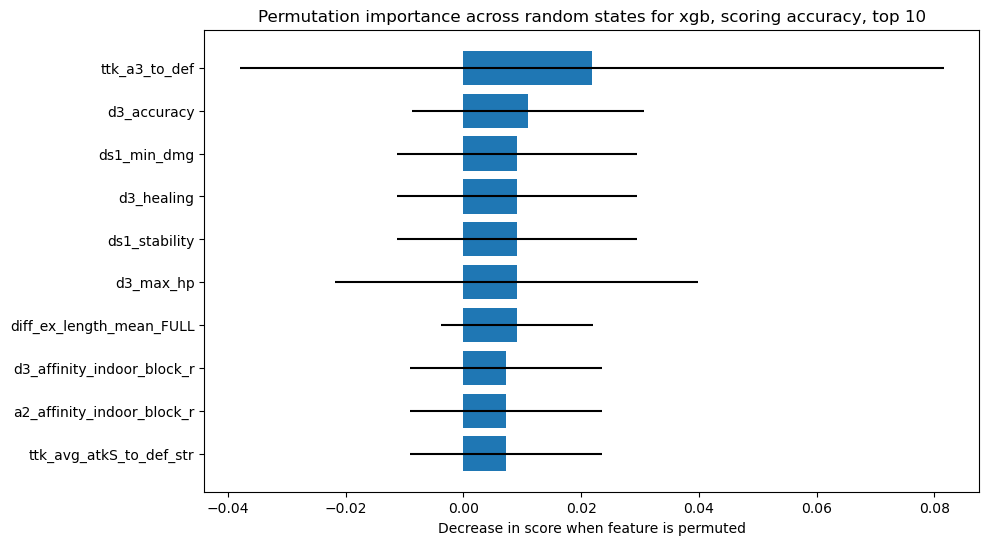

In [160]:
p = Path("../results/grid_pipe")
model_n = "xgb"

scoring = "accuracy"
n_repeats = 5

all_rows = []

for r in random_states:
    with open(p / f"{model_n}_seed{r}_best_pipe.pkl", "rb") as f:
        pipe = pickle.load(f)
    with open(p / f"{model_n}_seed{r}_X_test.pkl", "rb") as f:
        X_test = pickle.load(f)
    with open(p / f"{model_n}_seed{r}_y_test.pkl", "rb") as f:
        y_test = pickle.load(f)

    perm_res = permutation_importance(
        pipe,
        X_test,
        y_test,
        scoring=scoring,
        n_repeats=n_repeats,
        random_state=42,
        n_jobs=5,
    )

    for feat, mean_imp, std_imp in zip(X_test.columns, perm_res.importances_mean, perm_res.importances_std):
        all_rows.append({
            "seed": r,
            "feature": feat,
            "importance": float(mean_imp),
            "importance_std": float(std_imp),
        })

imp_df = pd.DataFrame(all_rows)

# aggregate across seeds
imp_summary = (imp_df.groupby("feature")["importance"].agg(mean="mean", std="std")
               .sort_values("mean", ascending=False).reset_index())

display(imp_summary.head(10))

# plot top-k
k = 10
top = imp_summary.head(k).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top["feature"], top["mean"], xerr=top["std"])
plt.title(f"Permutation importance across random states for {model_n}, scoring {scoring}, top {k}")
plt.xlabel("Decrease in score when feature is permuted")
plt.show()


<h3>XGB Built-in Importances</h3>

In [171]:
prep = best_pipe.named_steps["prep"]
xgb_clf = best_pipe.named_steps["clf"]
booster = xgb_clf.get_booster()

feat_names = prep.get_feature_names_out()
fmap = {f"f{i}": feat_names[i] for i in range(len(feat_names))}

# splits the base feature names
def base_feature(expanded_name: str) -> str:
    kind, rest = expanded_name.split("__",1)
    if kind == "num":
        return rest
    return rest.split("_",1)[0]

# get importances from xgb built-in
def grouped_importance_all_types(types=["weight", "gain", "cover", "total_gain", "total_cover"]) -> pd.DataFrame:
    merged = None

    for t in types:
        d = booster.get_score(importance_type=t)
        df = pd.DataFrame(d.items(), columns=["f", t])
        df["expanded"] = df["f"].map(fmap)
        df["original_feature"] = df["expanded"].apply(base_feature)

        g = df.groupby("original_feature")[t].sum().reset_index()

        merged = g if merged is None else merged.merge(g, on="original_feature", how="outer")

    merged = merged.fillna(0)

    return merged

imp_og = grouped_importance_all_types()

# show table
display(imp_og.sort_values("total_gain", ascending=False).head(20))


,original_feature,weight,gain,cover,total_gain,total_cover
152,rank,287.0,0.564294,28.588541,161.952377,8204.911133
155,ttk_a3_to_def,119.0,0.404322,23.323437,48.114281,2775.489014
51,d2,26.0,2.536507,58.281773,45.649525,774.069153
65,d3_ex_length,11.0,2.987514,20.019545,32.862659,220.214981
75,d4_evasion,38.0,0.756869,20.125107,28.761024,764.754028
156,ttk_a4_to_def,72.0,0.383398,22.254328,27.604683,1602.311646
34,a4,40.0,0.789951,50.697144,25.524712,1152.584745
62,d3_accuracy,7.0,3.344947,21.522287,23.414631,150.656006
8,a1_ex_length,49.0,0.427425,13.947008,20.943842,683.403381
64,d3_evasion,11.0,1.319304,18.742666,14.512342,206.169327


# Local Feature Importances

<h3>Local SHAP</h3>